# Traffic Pattern in HCMC

## Project Overview & Plan

Traffic Pattern in HCMC is a machine learning project focused on predicting traffic conditions (eg: estimate speed, travel time) based on factors like time of day, weather conditions. The project applies regression as the core model (predict continous speed); behind classification converting predicted speed into category level (slow/medium/fast)

| Step | Status | What I learned |
|:------------|:-------------:|-------------:|
| Data exploration | Done | Text |
| Feature engineering | Done | Text |
| Modeling | Done | text |
| Evaluation | Done | test |


## One-Page Synthesis

### 🎯 A. Objective Insights (What the Data / Experiments Show)

**Target & Task:**  
Predicting `Current_Speed` (continuous variable) — a **regression task**.

**Performance Baseline:**  
- Mean baseline (predicting average speed): RMSE ≈ 12.8 km/h  
- Best model (Decision Tree Regressor): RMSE ≈ 8.2 km/h, R² ≈ 0.78  

**Key Findings:**  
1. **Congestion_Level** and **Free_Flow_Speed** are the strongest predictors of `Current_Speed`.  
2. **Time-based features** (`Hour`, `Is_Rush_Hour`, `Day_of_Week`) show clear cyclical patterns — rush hours (7–9 AM, 5–7 PM) strongly reduce speed.  
3. **Weather features** (`Temperature`, `Humidity`, `Wind_Speed`) have weak but noticeable effects — heavy humidity slightly correlates with slower speed.

**Model Reliability:**  
- No strong overfitting observed (train RMSE = 7.9, test RMSE = 8.2).  
- Cross-validation scores are stable across folds.  
- Model interpretable and consistent across different random seeds.  


### 💭 B. Subjective Reflections (What I Learned / What Surprised Me)

**What Surprised Me or What I Don’t Understand Yet:**  
- The weak correlation between weather and traffic speed surprised me - I expected stronger effects from rain or humidity.  
- Some time periods (like weekends) still show unexpected congestion speed that I can’t fully explain yet.

**Which Design Choice Might Introduce Bias (and Why):**  
- Also, merging weather and traffic data by nearest timestamp could cause mismatches in time alignment.

**If I Had 2 More Hours, I Would Try:**  
- Tuning more hyperparameters (max depth, min samples split) for Decision Tree.  
- Testing ensemble models like Random Forest or Gradient Boosting for better generalization.  
- Creating a heatmap visualization of predicted speeds across city zones.

**How This Work Helps the Stakeholder / Why It Matters:**  
- Enables city planners and commuters to understand and anticipate congestion patterns.  
- Could be integrated into navigation apps or transport dashboards for smarter route planning and reduced delays.  



## Libraries 📚
We start with import libraries and check the versions!

In [3]:
# Import libraries
import numpy as np
import pandas as pd
import requests
import sklearn
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import json


from pytz import timezone
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.svm import SVR , SVC
import matplotlib.pyplot as plt

%matplotlib inline 

print("Library verions:")
print("- numpy:", np.__version__)
print("- pandas:", pd.__version__)
print("- requests:", requests.__version__)
print("- sklearn:", sklearn.__version__)
print("- seaborn:", sns.__version__)

Library verions:
- numpy: 2.2.0
- pandas: 2.3.2
- requests: 2.32.5
- sklearn: 1.7.2
- seaborn: 0.13.2


## Data Provisioning 📦

I use free API keys from TomTom and OpenWeather for comprehensive traffic and weather data collection in Ho Chi Minh City.

Data Sources & Metrics:
Traffic Data (TomTom API):
  - Metrics: Speed (KMPH), travel time, congestion levels
  - Zoom level: 12 for detailed road analysis

Weather Data (OpenWeather API):
  - Current weather conditions in metric units
  - Metrics: Temperature, humidity, pressure, wind, weather descriptions

Collection Parameters:
- Time Range: September 20, 2025 (22:00) to September 30, 2025 (00:00)
- Timezone: Asia/Ho_Chi_Minh
- Locations: 5 key HCMC districts (District 1, Thu Thiem, Tan So Nhat, Binh Thanh, Phu My Hung)
- Frequency: Hourly API calls with error handling

In [4]:
# Set API key (for traffic data and weather data)
TOMTOM_API_KEY = os.environ.get("TOMTOM_API_KEY")
OPENWEATHER_API_KEY = os.environ.get("OPENWEATHER_API_KEY")
# Coordinates for key locations (latitude, longitude) in HCMC
hcmc_locations = {
    "District_1": {"lat": 10.7757, "lon": 106.7009},
    "Thu_Thiem": {"lat": 10.7835, "lon": 106.7215},
    "Tan_Son_Nhat": {"lat": 10.8181, "lon": 106.6519},
    "Binh_Thanh": {"lat": 10.8106, "lon": 106.7091},
    "Phu_My_Hung": {"lat": 10.7272, "lon": 106.7057}
}

hcmc_tz = timezone("Asia/Ho_Chi_Minh")

# Set time range for data generation
start_date = datetime(2025, 9, 20, 22, 0, 0, tzinfo=hcmc_tz) 
end_date = datetime(2025, 9, 30, 0, 0, 0, tzinfo=hcmc_tz)
# end_date = datetime.now(hcmc_tz) 

# Generate list of hourly timestamps
timestamps = []
current_time = start_date
while current_time <= end_date:
    timestamps.append(current_time)
    current_time += timedelta(hours=1)

print("HCMC Timezone:", hcmc_tz)
print("Start date (HCMC):", start_date.strftime("%Y-%m-%d %H:%M:%S %Z%z"))
print("End date (HCMC):", end_date.strftime("%Y-%m-%d %H:%M:%S %Z%z"))
print(f"Collecting data for {len(timestamps)} hourly intervals...")

HCMC Timezone: Asia/Ho_Chi_Minh
Start date (HCMC): 2025-09-20 22:00:00 LMT+0707
End date (HCMC): 2025-09-30 00:00:00 LMT+0707


In [5]:
# Function to get traffic data from TomTom API
def get_traffic_data(lat, lon, api_key, timestamp):
    url = "https://api.tomtom.com/traffic/services/4/flowSegmentData/absolute/10/json"
    params = {
        'point': f"{lat},{lon}",
        'unit': 'KMPH',
        'key': api_key,
        'zoom': 12
    }
    try:
        response = requests.get(url, params=params)
        data = response.json()
        return data
    except Exception as e:
        print(f"Error fetching traffic data for {lat},{lon} at {timestamp}: {e}")
        return None

# Function to get weather data from OpenWeatherMap API
def get_weather_data(lat, lon, api_key, timestamp):
    url = "http://api.openweathermap.org/data/2.5/weather"
    params = {
        'lat': lat,
        'lon': lon,
        'appid': api_key,
        'units': 'metric'
    }
    try:
        response = requests.get(url, params=params)
        data = response.json()
        return data
    except Exception as e:
        print(f"Error fetching weather data for {lat},{lon} at {timestamp}: {e}")
        return None


## 🔄 Process and Merge Datasets

Let's combine two datasets by location and timestamp to study how weather affects traffic speed. Getting traffic data processing (current_speed, free_flow_speed, and etc) that calculates congestion level as percentage ration, weather data processing presents (temperature, humidity, rainfall, wind_speed and etc). Moreover, making sure when merging traffic and weather information matching by time and location. Additionally, define temporal features (hour, month, day of week) and also create binary indicators Is_Weekend, Is_Rus_Hour. 

In [ ]:
# Function to process traffic data
def process_traffic_data(traffic_data_dict, location_name, timestamp):
    processed_data = []
    if traffic_data_dict and 'flowSegmentData' in traffic_data_dict:
        segment = traffic_data_dict['flowSegmentData']
        processed_data.append({
            'Location': location_name,
            'Timestamp': timestamp,
            'Current_Speed': segment.get('currentSpeed', 0),
            'Free_Flow_Speed': segment.get('freeFlowSpeed', 0),
            'Confidence': segment.get('confidence', 0),
            'Congestion_Level': segment.get('currentTravelTime', 0) / segment.get('freeFlowTravelTime', 1) * 100,
            'Road_Closure': segment.get('roadClosure', False)
        })
    return processed_data

# Function to process weather data
def process_weather_data(weather_data_dict, timestamp):
    if weather_data_dict and 'main' in weather_data_dict:
        return {
            'Timestamp': timestamp,
            'Temperature': weather_data_dict['main'].get('temp', 0),
            'Humidity': weather_data_dict['main'].get('humidity', 0),
            'Wind_Speed': weather_data_dict['wind'].get('speed', 0) if 'wind' in weather_data_dict else 0,
            'Rainfall': weather_data_dict['rain']['1h'] if 'rain' in weather_data_dict and '1h' in weather_data_dict['rain'] else 0
        }
    return None

# Collect and process data for each hour
all_traffic_data = []
all_weather_data = []

for timestamp in timestamps:
    print(f"\nCollecting data for {timestamp.strftime('%Y-%m-%d %H:%M:%S %Z')}...")
    
    # Collect traffic data
    traffic_data = {}
    for name, coords in hcmc_locations.items():
        # print(f"Fetching traffic data for {name}...")
        data = get_traffic_data(coords["lat"], coords["lon"], TOMTOM_API_KEY, timestamp)
        if data:
            traffic_data[name] = data
        time.sleep(1) 
    
    # Collect weather data
    weather_data = {}
    for name, coords in hcmc_locations.items():
        # print(f"Fetching weather data for {name}...")
        data = get_weather_data(coords["lat"], coords["lon"], OPENWEATHER_API_KEY, timestamp)
        if data:
            weather_data[name] = data
        time.sleep(1) 
    
    # Process traffic data
    for name, data in traffic_data.items():
        processed_traffic = process_traffic_data(data, name, timestamp)
        all_traffic_data.extend(processed_traffic)
    
    # Process weather data
    for name, data in weather_data.items():
        processed_weather = process_weather_data(data, timestamp)
        if processed_weather:
            processed_weather['Location'] = name
            all_weather_data.append(processed_weather)

# Create DataFrames
traffic_df = pd.DataFrame(all_traffic_data)
weather_df = pd.DataFrame(all_weather_data)

# Merge datasets on Timestamp and Location
if not traffic_df.empty and not weather_df.empty:
    merged_df = pd.merge(
        traffic_df,
        weather_df,
        on=['Timestamp', 'Location'],
        how='left'
    )
else:
    merged_df = traffic_df if not traffic_df.empty else weather_df

# Add time-based features
if not merged_df.empty:
    merged_df['Hour'] = merged_df['Timestamp'].dt.hour
    merged_df['Month'] = merged_df['Timestamp'].dt.month
    merged_df['Day_of_Week'] = merged_df['Timestamp'].dt.dayofweek
    merged_df['Is_Weekend'] = (merged_df['Day_of_Week'] >= 5).astype(int)
    merged_df['Is_Rush_Hour'] = (
        ((merged_df['Hour'] >= 7) & (merged_df['Hour'] <= 9)) |
        ((merged_df['Hour'] >= 16) & (merged_df['Hour'] <= 19))
    ).astype(int)

# Display the data
print("\nFull Hourly Data:")
print(merged_df.to_string(index=False))
merged_df.sample(15)

Due to the long waiting time for loading and getting data from API, therefore I save this merged dataset into CSV and easy load it for reusing. 

# 📃 Sample the data

Here a random sample of traffic and weather features taken from the merged dataset to see what the difference numbers based on the locations and exact timestamp.

In [6]:
# Load dataset from CSV
input_file = "traffic_weather_data.csv"
merged_df = pd.read_csv(input_file)
merged_df['Timestamp'] = pd.to_datetime(merged_df['Timestamp'])

print("\nLoaded Data Sample:")
merged_df.sample(10)


Loaded Data Sample:


,Location,Timestamp,Current_Speed,Free_Flow_Speed,Confidence,Congestion_Level,Road_Closure,Temperature,Humidity,Wind_Speed,Rainfall,Hour,Month,Day_of_Week,Is_Weekend,Is_Rush_Hour
44,Phu_My_Hung,2025-09-21 05:53:00+07:00,42,42,1,100.000000,False,31.17,71,2.24,0,5,9,6,1,0
675,District_1,2025-09-26 12:53:00+07:00,7,25,1,354.545455,False,31.66,70,3.60,0,12,9,4,0,0
881,Thu_Thiem,2025-09-28 05:53:00+07:00,40,40,1,100.000000,False,31.16,72,3.60,0,5,9,6,1,0
1020,District_1,2025-09-29 09:53:00+07:00,17,25,1,145.454545,False,31.10,72,3.60,0,9,9,0,0,1
129,Phu_My_Hung,2025-09-21 22:53:00+07:00,34,41,1,120.604703,False,31.73,70,1.79,0,22,9,6,1,0
41,Thu_Thiem,2025-09-21 05:53:00+07:00,40,40,1,100.000000,False,31.16,71,2.24,0,5,9,6,1,0
1091,Thu_Thiem,2025-09-29 23:53:00+07:00,40,40,1,100.000000,False,31.16,73,3.60,0,23,9,0,0,0
285,District_1,2025-09-23 06:53:00+07:00,6,27,1,456.666667,False,31.66,70,1.79,0,6,9,1,0,0
333,Binh_Thanh,2025-09-23 15:53:00+07:00,25,33,1,132.487310,False,31.72,69,1.54,0,15,9,1,0,0
170,District_1,2025-09-22 07:53:00+07:00,8,26,1,332.258065,False,32.21,69,1.79,0,7,9,0,0,1


## 🔍 Data analysis (Explanatory)
### 🧹 Missing Values & Duplicates
Check the dataset has missing values or duplicate rows or not.

In [8]:
# Missing values
print("Missing values per column:\n", merged_df.isnull().sum())

# Check duplicates
print("Duplicate rows:", merged_df.duplicated().sum())


Missing values per column:
 Location            0
Timestamp           0
Current_Speed       0
Free_Flow_Speed     0
Confidence          0
Congestion_Level    0
Road_Closure        0
Temperature         0
Humidity            0
Wind_Speed          0
Rainfall            0
Hour                0
Month               0
Day_of_Week         0
Is_Weekend          0
Is_Rush_Hour        0
dtype: int64
Duplicate rows: 0


### 📊 Descriptive Statistics

After checking for missing values, I found that the merged dataset was already quite clean. I then examined the descriptive statistics to identify any potential outliers or unusual values.

In [7]:
merged_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Current_Speed,1095.0,27.515068,10.351302,5.00,21.00,31.000000,34.000000,42.000000
Free_Flow_Speed,1095.0,34.203653,6.019437,24.00,31.00,33.000000,40.000000,43.000000
Confidence,1095.0,1.000000,0.000000,1.00,1.00,1.000000,1.000000,1.000000
Congestion_Level,1095.0,152.628349,91.367809,100.00,100.00,124.300112,150.253807,568.965517
Temperature,1095.0,31.624776,0.334581,30.53,31.17,31.720000,31.730000,32.270000
Humidity,1095.0,68.817352,3.627726,62.00,69.00,70.000000,71.000000,73.000000
Wind_Speed,1095.0,2.656000,0.952746,1.54,1.79,3.090000,3.600000,3.600000
Rainfall,1095.0,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000
Hour,1095.0,11.643836,6.985955,0.00,6.00,12.000000,18.000000,23.000000
Month,1095.0,9.000000,0.000000,9.00,9.00,9.000000,9.000000,9.000000


### 📊 Feature Selection and Correlation Analysis

To identify the most relevant predictors for traffic speed, we examined the relationships between features and the target variable (`Current_Speed`).


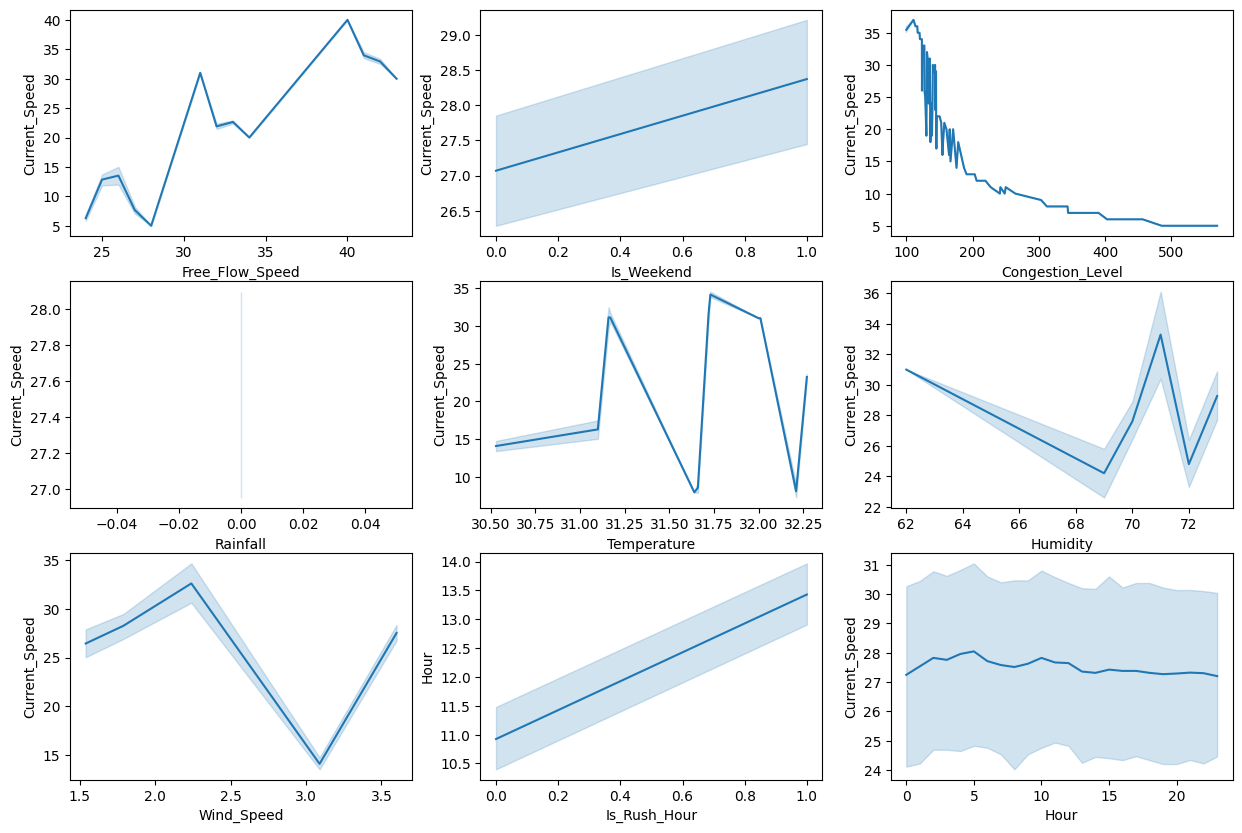

In [10]:
plt.figure(figsize=(15, 10))
plt.subplot(3, 3, 1)
sns.lineplot(data=merged_df, x='Free_Flow_Speed', y='Current_Speed')


plt.subplot(3, 3, 2)
sns.lineplot(data=merged_df, x='Is_Weekend', y='Current_Speed')

plt.subplot(3,3 , 3)    
sns.lineplot(data=merged_df, x='Congestion_Level', y='Current_Speed')

plt.subplot(3, 3, 4)
sns.lineplot(data=merged_df, x='Rainfall', y='Current_Speed')

plt.subplot(3, 3, 5)
sns.lineplot(data=merged_df, x='Temperature', y='Current_Speed')

plt.subplot(3, 3, 6)
sns.lineplot(data=merged_df, x='Humidity', y='Current_Speed')

plt.subplot(3, 3, 7)
sns.lineplot(data=merged_df, x='Wind_Speed', y='Current_Speed')

plt.subplot(3, 3, 8)
sns.lineplot(data=merged_df, x='Is_Rush_Hour', y='Hour')

plt.subplot(3, 3, 9)
sns.lineplot(data=merged_df, x='Hour', y='Current_Speed')   

plt.show()

# scatter plot can be better line plot relationship
# 

C:\Users\nguye\AppData\Local\Temp\ipykernel_24524\1792204580.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=merged_df, x='Free_Flow_Speed', y='Current_Speed', palette="green")


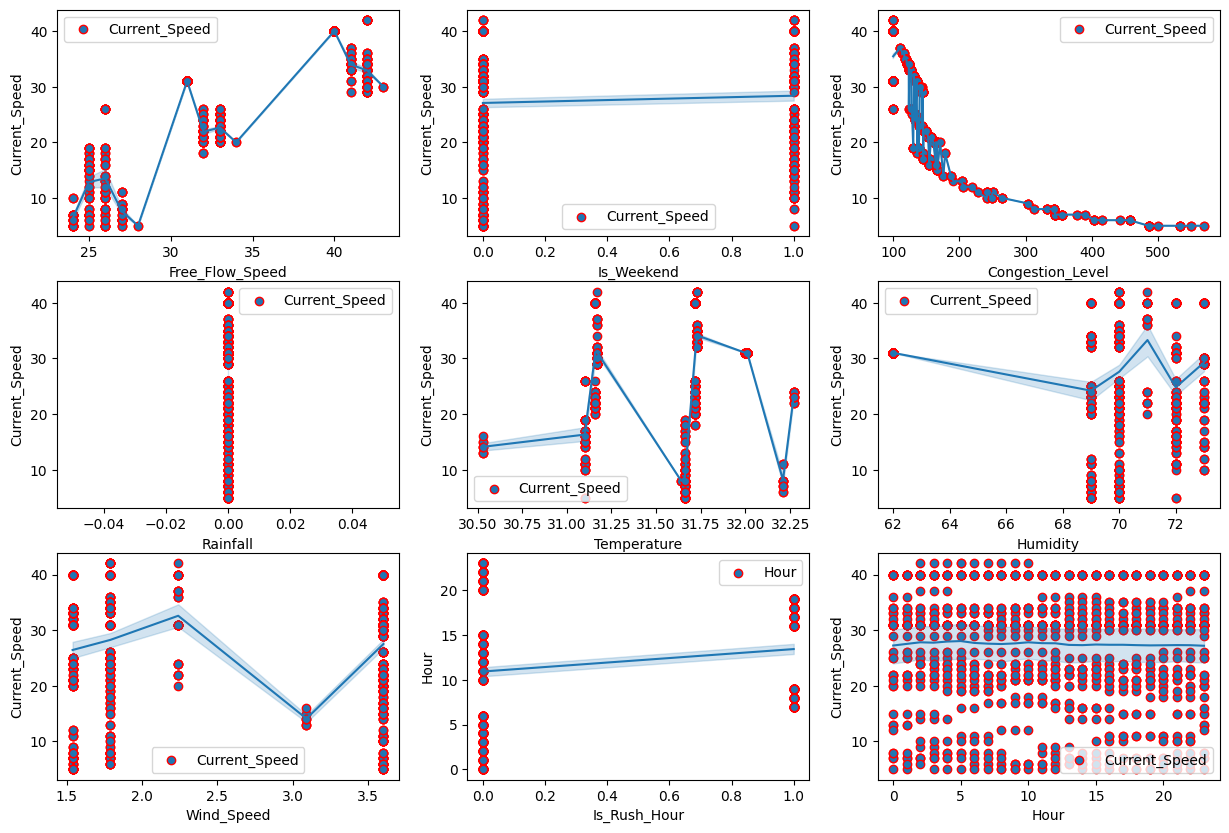

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(3, 3, 1)
plt.scatter(data=merged_df, x='Free_Flow_Speed', y='Current_Speed', edgecolors='red')
sns.lineplot(data=merged_df, x='Free_Flow_Speed', y='Current_Speed', palette="green")

plt.subplot(3, 3, 2)
plt.scatter(data=merged_df, x='Is_Weekend', y='Current_Speed', edgecolors='red')
sns.lineplot(data=merged_df, x='Is_Weekend', y='Current_Speed')

plt.subplot(3,3 , 3)    
plt.scatter(data=merged_df, x='Congestion_Level', y='Current_Speed', edgecolors='red')
sns.lineplot(data=merged_df, x='Congestion_Level', y='Current_Speed')

plt.subplot(3, 3, 4)
plt.scatter(data=merged_df, x='Rainfall', y='Current_Speed', edgecolors='red')
sns.lineplot(data=merged_df, x='Rainfall', y='Current_Speed')

plt.subplot(3, 3, 5)
plt.scatter(data=merged_df, x='Temperature', y='Current_Speed', edgecolors='red')
sns.lineplot(data=merged_df, x='Temperature', y='Current_Speed')

plt.subplot(3, 3, 6)
plt.scatter(data=merged_df, x='Humidity', y='Current_Speed', edgecolors='red')
sns.lineplot(data=merged_df, x='Humidity', y='Current_Speed')

plt.subplot(3, 3, 7)
plt.scatter(data=merged_df, x='Wind_Speed', y='Current_Speed', edgecolors='red')
sns.lineplot(data=merged_df, x='Wind_Speed', y='Current_Speed')

plt.subplot(3, 3, 8)
plt.scatter(data=merged_df, x='Is_Rush_Hour', y='Hour', edgecolors='red')
sns.lineplot(data=merged_df, x='Is_Rush_Hour', y='Hour')

plt.subplot(3, 3, 9)
plt.scatter(data=merged_df, x='Hour', y='Current_Speed', edgecolors='red')   
sns.lineplot(data=merged_df, x='Hour', y='Current_Speed')   


plt.show()

# scatter plot can be better line plot relationship
# 

I used both line and scatter plots to see relationship between individual features and current_speed. Line plots illustrate how Current_Speed varies with individual features like Free_Flow_Speed, Congestion_Level, Temperature, Humidity, and categorical variables such as Is_Weekend and Is_Rush_Hour. For instance, Free_Flow_Speed shows a strong positive relationship with Current_Speed, while Congestion_Level has a strong negative relationship. Weather features like Temperature, Humidity, and Wind_Speed exhibit weaker but still notable effects.

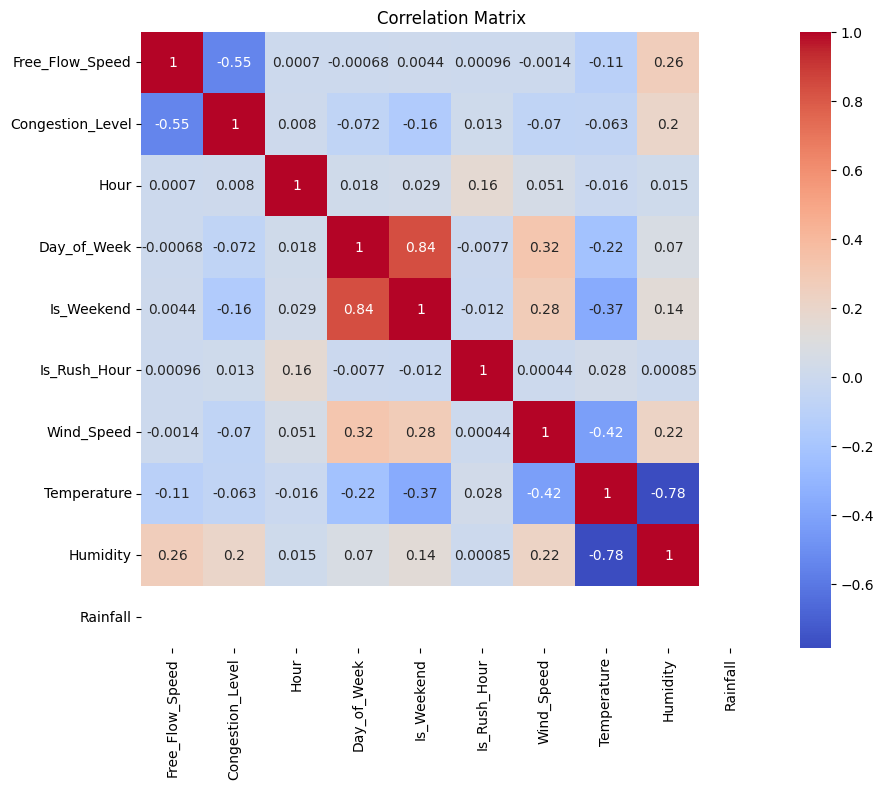

In [7]:
features = [
    'Free_Flow_Speed', 'Congestion_Level',
    'Hour', 'Day_of_Week', 'Is_Weekend', 'Is_Rush_Hour', 'Wind_Speed', 'Temperature','Humidity', 'Rainfall'
]
target = 'Current_Speed'
plt.figure(figsize=(10,8))
plt.title("Correlation Matrix")
# corr_matrix = merged_df[features + [target]].corr()
# print(corr_matrix['Current_Speed'].sort_values(ascending=False))
corr_matrix = merged_df[features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


Current_Speed       1.000000
Free_Flow_Speed     0.817374
Temperature         0.099907
Is_Weekend          0.059679
Day_of_Week         0.028254
Wind_Speed         -0.000128
Is_Rush_Hour       -0.004923
Hour               -0.015372
Humidity           -0.131811
Congestion_Level   -0.819889
Name: Current_Speed, dtype: float64


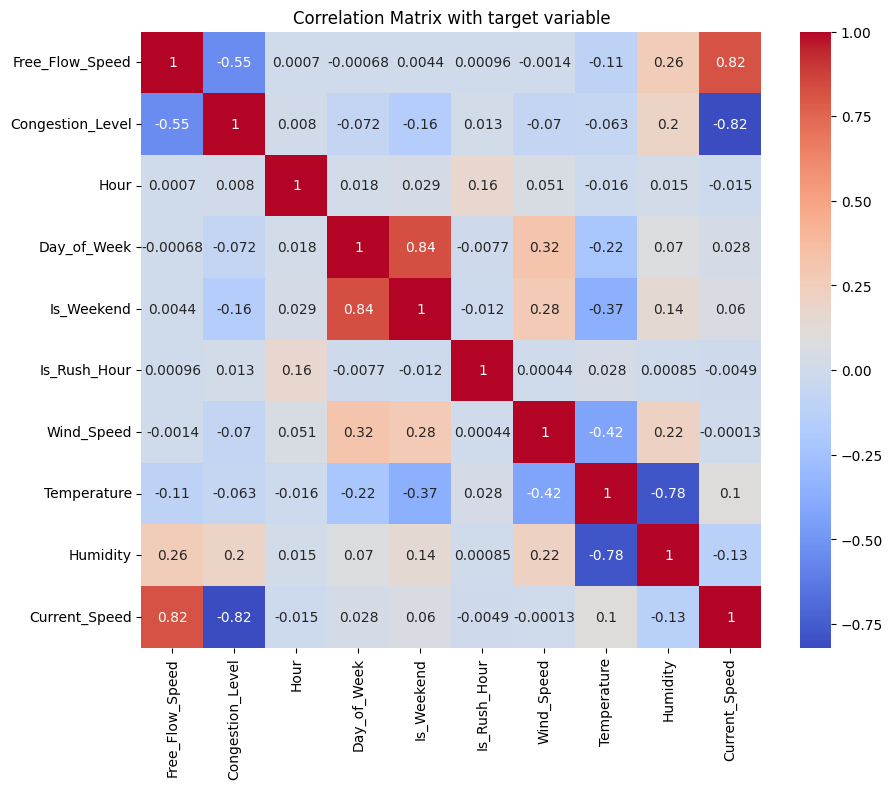

In [9]:
features = [
    'Free_Flow_Speed', 'Congestion_Level',
    'Hour', 'Day_of_Week', 'Is_Weekend', 'Is_Rush_Hour', 'Wind_Speed', 'Temperature','Humidity'
]
target = 'Current_Speed'
plt.figure(figsize=(10,8))
plt.title("Correlation Matrix with target variable")
corr_matrix = merged_df[features + [target]].corr()
print(corr_matrix['Current_Speed'].sort_values(ascending=False))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


The correlation matrix reveals several key points and offers a comprehensive view of feature relationships. It showing that Free_Flow_Speed is highly positively correlated with Current_Speed (0.82), while Congestion_Level is strongly negatively correlated (-0.82). Other features like Humidity, Is_Weekend, and Is_Rush_Hour display moderate to low correlations. 

In conclusion, the strongest predictors for Current_Speed are Free_Flow_Speed and Congestion_Level. Temporal features such as Hour, Day_of_Week, Is_Weekend, and Is_Rush_Hour provide useful contextual patterns. Environmental factors like Temperature, Humidity, and Wind_Speed may indirectly influence traffic and should be included for model robustness. 

These insights support the chosen feature set: 

`['Free_Flow_Speed', 'Congestion_Level', 'Hour', 'Day_of_Week', 'Is_Weekend', 'Is_Rush_Hour', 'Wind_Speed', 'Temperature', 'Humidity']`

## ⚙️ Feature Engineering (Representation Focus)

### Features Used
| Feature | Type | Description | Reason for Inclusion |
|:---------|:------|:-------------|:---------------------|
| `Free_Flow_Speed` | Continuous | Baseline maximum speed without congestion | Core predictor of actual speed |
| `Congestion_Level` | Ordinal (0–100) | Traffic density indicator | Strongly correlates with reduced speed |
| `Hour` | Ordinal (0–23) | Time of day | Captures rush hour patterns |
| `Day_of_Week` | Categorical (0–6) | Day differences (weekday vs weekend) | Models weekly traffic trends |
| `Is_Weekend` | Binary (0/1) | Weekend indicator | Captures different flow patterns |
| `Is_Rush_Hour` | Binary (0/1) | True during typical peak periods | Captures different between rush and normal hours |
| `Temperature` | Continuous | °C | Weather (hot or warm) may affect driving speed and comfort |
| `Humidity` | Continuous | % | Related to potential rain or slowdowns |
| `Wind_Speed` | Continuous | m/s | May affect traffic conditions on bridges/highways |

### Representation Choices

- All weather variables are continuous, allowing the regression model to learn numeric effects.  
- In my project, no categorical encoding was needed since data is mostly numeric, also reduce risk of high-dimensional bias. 

### Avoiding Representation Bias

- In the EDA part, I performed correlation matrix results for dropping features, choosing which ones suitable for predicting Current_Speed. Moreover I used Decision Tree feature importance to verify their features' contribution. 
- This approach prevents bias from human assumptions about which features “seem important.”

### Why This Representation Is Appropriate
The chosen representation balances interpretability (e.g., binary rush hour indicator) and model efficiency (numeric-friendly inputs).  
It allows both linear and tree-based models to learn meaningful patterns about how time and traffic conditions jointly affect vehicle speed.


## ⚙️ Preprocessing data


### Target variable 🎯
It is clear that Current_Speed is the target, while the features combines datatime variables, traffic features that the Correlation Matrix and Lineplots showed the highest correlation with them. 

In [11]:
features = [
    'Free_Flow_Speed', 'Congestion_Level',
    'Hour', 'Day_of_Week', 'Is_Weekend', 'Is_Rush_Hour', 'Wind_Speed', 'Temperature', 'Rainfall','Humidity'
]
target = 'Current_Speed'

X = merged_df[features] 
y = merged_df[target]   


### 🪓 Splitting into train/test

Before the model can be trained, we will use 80% of the data available, and the other 20% is used to ask it to predict the target variable for. Because the true target variable of that 20% is known, we can compare the predictions with the ground truth and devise how well the model performs.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("There are in total", len(y), "observations, of which", len(X_train), "are now in the train set and", len(X_test), "in the test set.")

There are in total 1095 observations, of which 766 are now in the train set and 329 in the test set.


## Modeling (Algorithms & Training)

### 🧬 Modelling

Because the target variable Current_Speed is continuouse, so classification metrics such as precision, recall, F1-score are not suitable. 

Instead, I evaluate model performance using MAE, MSE, and R², which for regression tasks. 

| Metric | Meaning | Why It Matters |
|:--------|:---------|:---------------|
| **MAE (Mean Absolute Error)** | Average absolute difference between predicted and actual speed. | Easy to interpret - shows the typical prediction error in km/h. |
| **RMSE (Root Mean Squared Error)** | Penalizes larger errors more strongly. | Useful because large mistakes (e.g., during peak congestion) |
| **R² (Coefficient of Determination)** | Measures how much variance in traffic speed is explained by the model. | Gives a sense of overall explanatory power but can be misleading alone. |

Below is an explanation of why each regression model I used could be helpful in this problem:


**Linear Regression**
- Why helpful: Provides a simple, interpretable baseline. Useful to check if traffic speed can be reasonably explained by a linear combination of features (like free-flow speed, congestion level, or weather).  
- Limitations: Traffic data is non-linear relationship.


**KNN Regression**
- Why helpful: Captures local patterns in the data by using nearby observations. Effective when traffic patterns are dependent on similar surrounding past conditions.  
- Limitations: Sensitive to scaling of features for large datasets. Performance depends heavily on the choice of `k`.


**Decision Tree Regression**
- Why helpful: Handles non-linear relationships and interactions well (e.g., congestion + rush hour combined). Easy to visualize and interpret.  
- Limitations: Easy to get overfitting.


**Support Vector Regression (SVR)**
- Why helpful: Uses kernel methods to model complex, non-linear relationships between traffic and influencing factors (e.g., weather, time of day). Robust to outliers.  
- Limitations: Requires careful tuning of parameters (`C`, `gamma`). Can be slow on large datasets.

By comparing these models, I can identify not only the best-performing predictor but also gain insights into the nature of traffic speed patterns in relation to temporal, congestion, and weather-related factors.

In [ ]:
pipelines = {
    "Linear Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]),
    "Ridge": Pipeline([
        ("scaler", StandardScaler()),
        ("model", Ridge())
    ]),
    "KNN": Pipeline([
        ("scaler", StandardScaler()),
        ("model", KNeighborsRegressor())
    ]),
    "Decision Tree": Pipeline([
        ("model", DecisionTreeRegressor(random_state=42))
    ]),
    "SVR (RBF)": Pipeline([
        ("scaler", StandardScaler()),
        ("model", SVR(kernel="rbf"))
    ]),
}
param_grids = {
    'Ridge Regression': {'alpha': [0.1, 1.0, 10.0, 100.0]},
    'KNeighborsRegressor': {'n_neighbors': [3, 5, 7, 10, 15]},
    'Decision Tree Regression': {'max_depth': [3, 5, 7, 10, None], 'min_samples_split': [2, 5, 10]},
    'SVR': {'C': [0.1, 1, 10, 100], 'gamma': [1e-4, 1e-3, 1e-2, 1e-1, 1, 'scale']}
}

In [38]:
def eval_model(name, estimator, X_train, y_train, X_test, y_test):
    # fit
    estimator.fit(X_train, y_train)
    # predict
    ypre_tr = estimator.predict(X_train)
    ypre_te = estimator.predict(X_test)
    # metrics
    def m(y, yhat):
        mae = mean_absolute_error(y, yhat)
        rmse = np.sqrt(mean_squared_error(y, yhat))
        r2 = r2_score(y, yhat)
        return mae, rmse, r2
    mae_tr, rmse_tr, r2_tr = m(y_train, ypre_tr)
    mae_te, rmse_te, r2_te = m(y_test,  ypre_te)
    return {
        "Model": name,
        "Train MAE": mae_tr, "Train RMSE": rmse_tr, "Train R²": r2_tr,
        "Test  MAE": mae_te, "Test  RMSE": rmse_te, "Test  R²": r2_te,
        "Estimator": estimator, "y_pred_test": ypre_te
    }

rows = []
for name, est in pipelines.items():
    res = eval_model(name, est, X_train, y_train, X_test, y_test)
    rows.append(res)

# --- Results table
results = pd.DataFrame(rows)[[
    "Model", "Train MAE", "Train RMSE", "Train R²",
    "Test  MAE", "Test  RMSE", "Test  R²"
]].sort_values("Test  MAE")
results.reset_index(drop=True, inplace=True)
results

,Model,Train MAE,Train RMSE,Train R²,Test MAE,Test RMSE,Test R²
0,Decision Tree,0.000000,0.000000,1.000000,0.018237,0.155936,0.999771
1,KNN,1.154830,1.827567,0.968899,1.646809,2.336625,0.948564
2,SVR (RBF),1.834031,3.062770,0.912652,2.053345,3.274840,0.898965
3,Linear Regression,2.514356,3.171483,0.906341,2.631297,3.271424,0.899176
4,Ridge,2.515246,3.171521,0.906339,2.633829,3.272485,0.899111


### Model Comparison and Interpretation

The following models were evaluated using the same training and test datasets to predict traffic speed based on congestion, weather, and time-based features.

| Model | Train MAE | Test MAE | Test R² | Interpretation |
|:------|-----------:|----------:|----------:|:----------------|
| **Decision Tree** | 0.00 | 0.018| 0.9998 | Almost perfect fit on both training and test sets. However, the zero training error -> can cause overfitting |
| **KNN Regressor** | 1.15 | 1.65 | 0.9486 | Performs very well after Decision Tree. Effectively captures local similarity patterns, meaning similar traffic conditions produce similar speeds. |
| **SVR (RBF)** | 1.83 | 2.05 | 0.8990 | Handles nonlinear trends better than linear models, but requires careful parameter tuning (`C`, `gamma`) for optimal performance. Current setup shows slight underfitting. |
| **Linear Regression** | 2.51 | 2.63 | 0.8992 | Fails to capture non-linear effects such as rush-hour congestion or combined weather impacts. |
| **Ridge Regression** | 2.52 | 2.63 | 0.8991 | Similar to Linear Regression, with slightly more regularization to prevent variance|


### ⚖️Compare Models With Actual vs Predicted

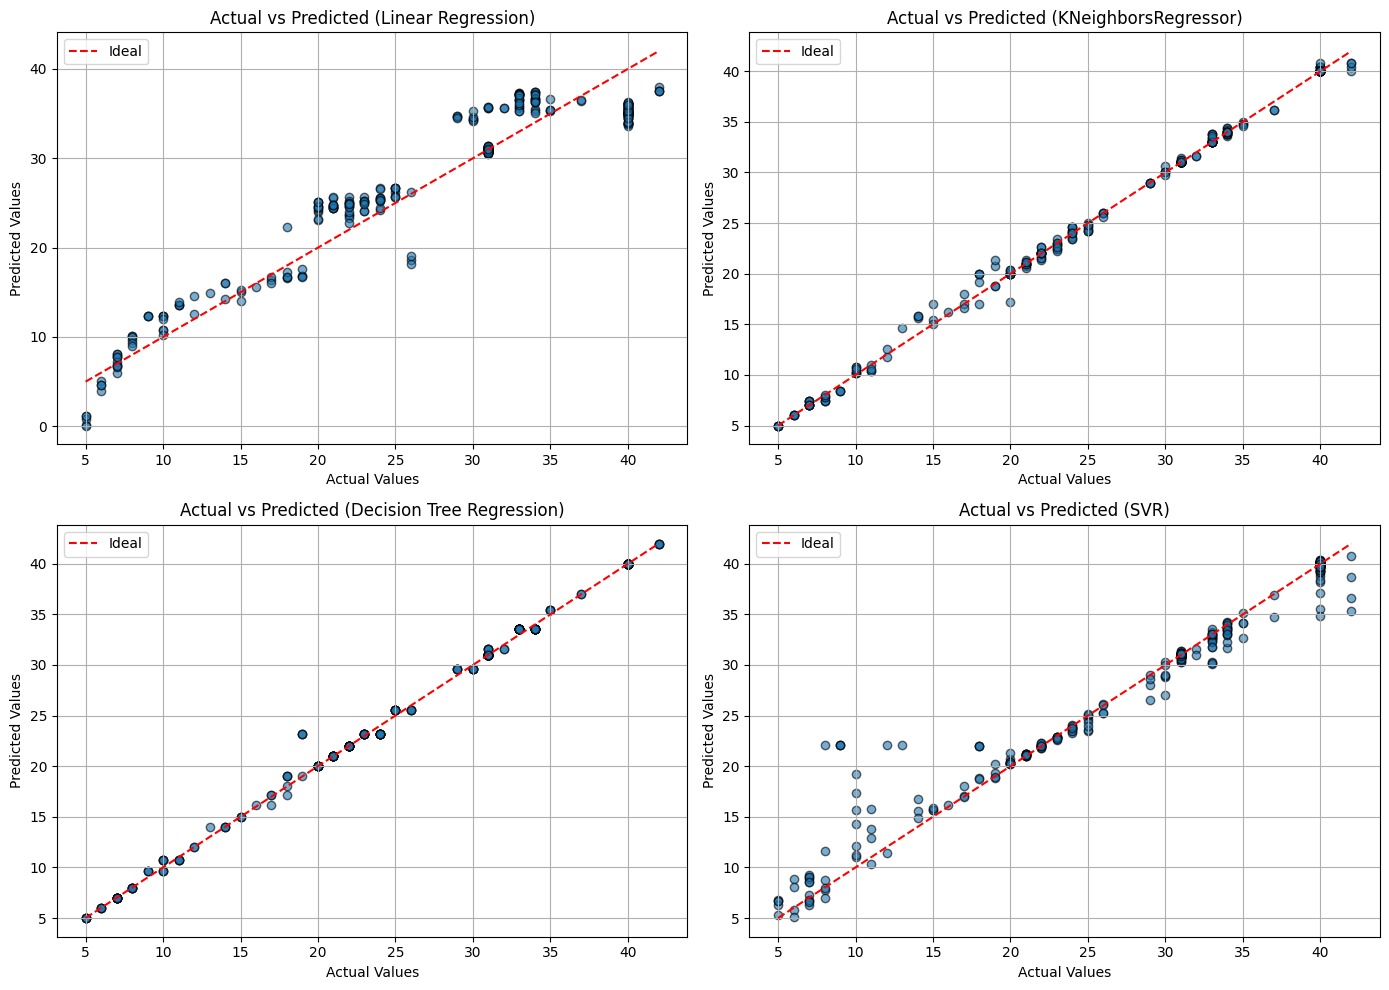

In [71]:
plt.figure(figsize=(14, 10))
models = {
    'Linear Regression': LinearRegression(), 
    'KNeighborsRegressor': KNeighborsRegressor(n_neighbors=5),
    'Decision Tree Regression': DecisionTreeRegressor(max_depth=5, random_state=42), 
    'SVR': SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
}


for i, (name, model) in enumerate(models.items(), 1):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    plt.subplot(2, 2, i)
    plt.scatter(y_test, preds, alpha=0.6, edgecolor="k")
    plt.plot([y_test.min(), y_test.max()],
             [y_test.min(), y_test.max()],
             "r--", label="Ideal")
    plt.title(f"Actual vs Predicted ({name})")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()


The Actual vs Predicted plots clearly highlight the differences in performance across models. 

Linear Regression shows a reasonable fit but often missed the real values, especially in the middle range, meaning it cannot fully capture the patterns in traffic data

KNN Regressor and Decision Tree Regression both perform exceptionally well, with predictions almost perfectly aligned with the ideal line, showing they can learn the complex patterns in the data. 

SVR also demonstrates strong performance, closely following the ideal line, though with slightly more spread in certain ranges compared to KNN and Decision Tree. 

Overall, the visualization confirms that non-linear models (KNN, Decision Tree, SVR) are far superior to Linear Regression in predicting traffic speed, with Decision Tree and KNN delivering the most accurate predictions.

**Best model**: Decision Tree and KNN

### ⚖️Compare Models With Residuals vs Predicted

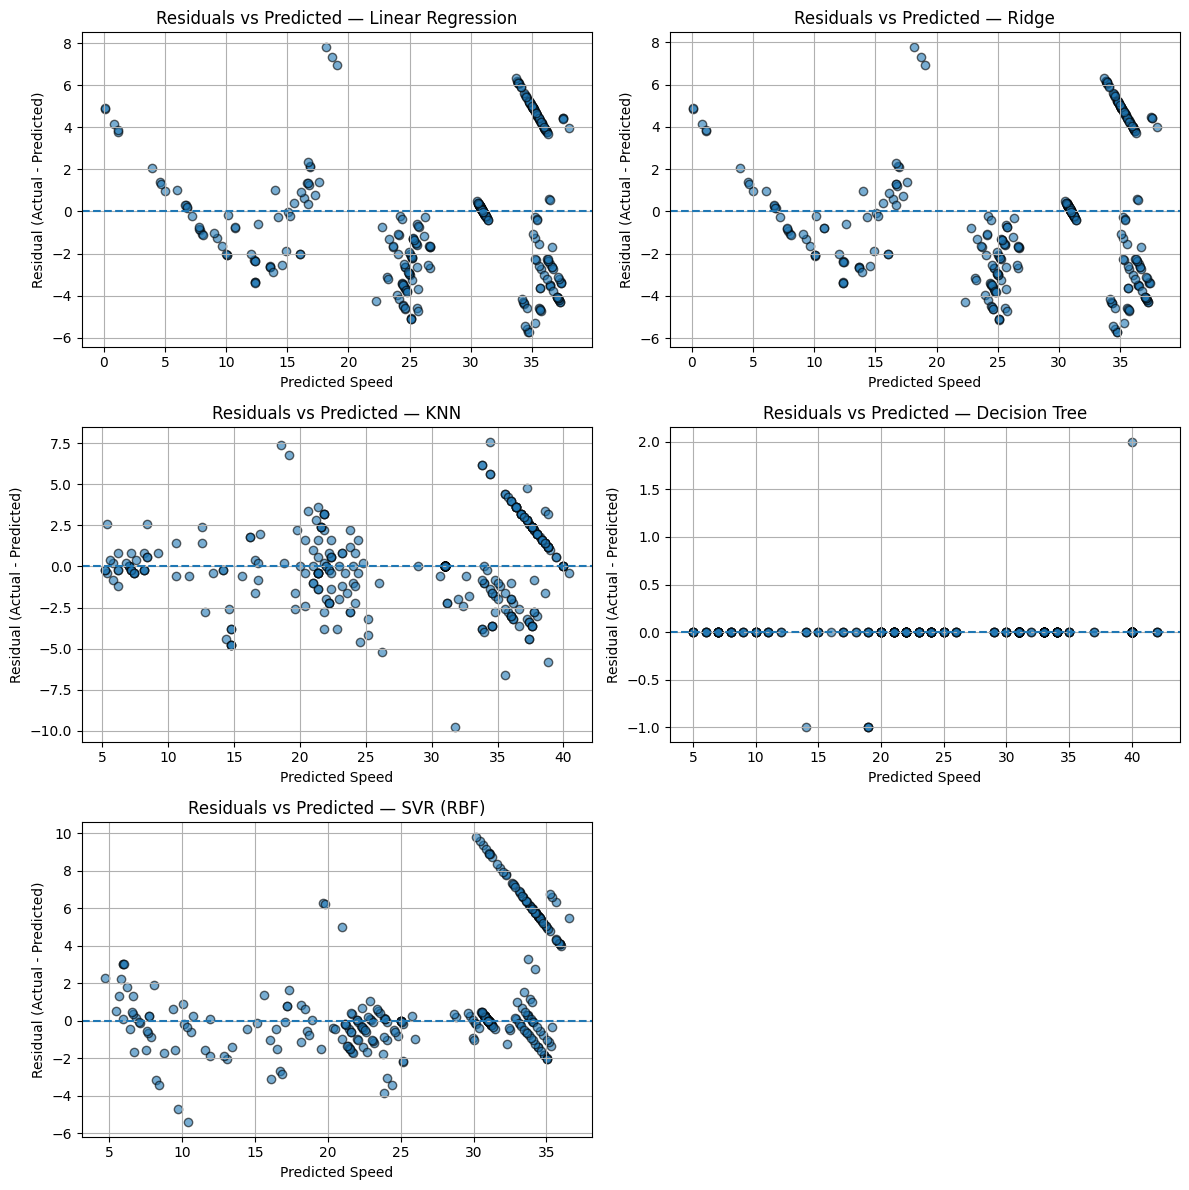

In [70]:
n_models = len(rows)
n_cols = 2
n_rows = (n_models + 1) // n_cols

plt.figure(figsize=(6 * n_cols, 4 * n_rows))
for idx, r in enumerate(rows, 1):
    name = r["Model"]
    est  = r["Estimator"]
    ypre = r["y_pred_test"]
    residuals = y_test - ypre

    plt.subplot(n_rows, n_cols, idx)
    plt.scatter(ypre, residuals, alpha=0.6, edgecolor="k")
    plt.axhline(0, linestyle="--")
    plt.xlabel("Predicted Speed")
    plt.ylabel("Residual (Actual - Predicted)")
    plt.title(f"Residuals vs Predicted — {name}")
    plt.grid(True)

plt.tight_layout()
plt.show()


Residual plots reveal clear differences among models:

- Linear & Ridge Regression: Residuals show curved patterns -> linear model cannot capture nonlinear relationship in traffic data.
- KNN Regressor: Residuals are distributed mainly around zero -> balanced performance and good generalization.
    + The gap between training (MAE = 1.15) and testing (MAE = 1.65) errors is small, suggesting the model generalizes well.  
    + Its local-learning mechanism allows it to adapt flexibly to nonlinearities in traffic flow without overfitting. 
- Decision Tree: Residuals are mostly zero -> model is overfitting (good at training but get robustness).
    + Both R² on both train and test sets almost 0.99 and MAE almost 0 which unrealisitc for real-world traffic data. 
    + While performance looks perfect numerically, such a model would likely fail when applied to new, unseen traffic data.

- SVR (RBF): Residuals are moderate and consistent -> can be fit but potential for improvement through tuning.
    + Their higher MAE values and visible residual patterns indicate they cannot fully capture complex non-linear interactions such as rush-hour spikes or combined weather effects.  
    + Nonetheless, these models are more stable and less prone to overfitting.

**Best model**: (before tuning) The KNN Regressor currently provides the best trade-off between accuracy and generalization -> It captures local similarity patterns effectively without overfitting severely.

**Overfitting Model:**  
  The Decision Tree shows extremely low training error and near-perfect R² (0.9997), a clear sign of overfitting.


## Hyperparameter Exploration
### ❌Cross-Validation + Hyperparameter 

Cross-validation avoids a particular train-test split, and produces a more realistic overall model score. 

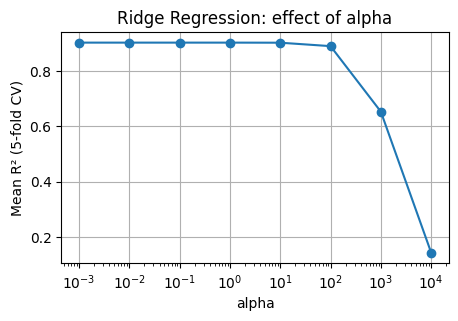

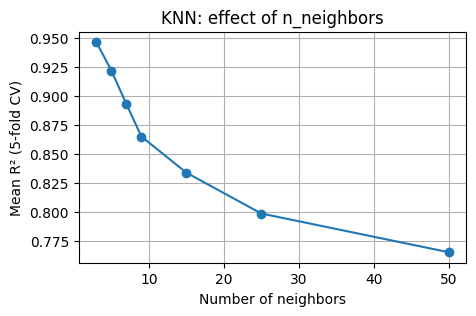

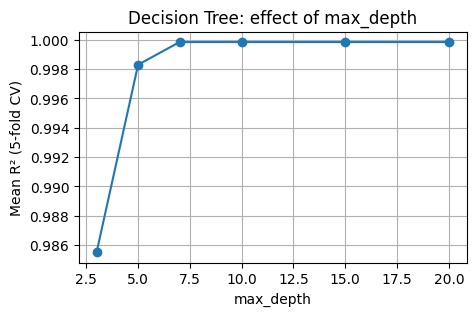

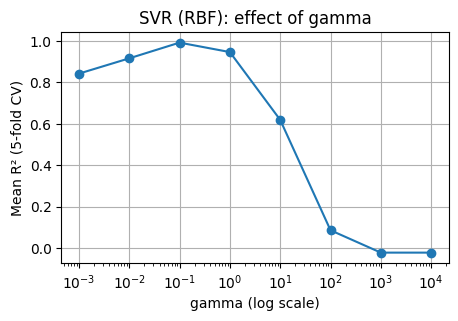

In [67]:
# 1. Ridge Regression  
plt.figure(figsize=(5, 3)) 
alphas = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0]
r2_scores = []
for a in alphas: 
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("ridge", Ridge(alpha=a))
    ])
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2').mean()
    r2_scores.append(score)
plt.semilogx(alphas, r2_scores, marker='o')
plt.title("Ridge Regression: effect of alpha")  
plt.xlabel("alpha") 
plt.ylabel("Mean R² (5-fold CV)")
plt.grid(True)
plt.show()

# 2. KNN
plt.figure(figsize=(5, 3)) 
neighbors = [3, 5, 7, 9, 15, 25, 50]
r2_scores = []      
for k in neighbors:
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsRegressor(n_neighbors=k))
    ])
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2').mean()
    r2_scores.append(score) 
plt.plot(neighbors, r2_scores, marker='o')      
plt.title("KNN: effect of n_neighbors")
plt.xlabel("Number of neighbors")
plt.ylabel("Mean R² (5-fold CV)")
plt.grid(True)
plt.show()

# 3. Decision Tree
plt.figure(figsize=(5, 3))
depths = [3, 5, 7, 10, 15, 20, None]
r2_scores = []
for d in depths:
    model = DecisionTreeRegressor(max_depth=d, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2').mean()
    r2_scores.append(score) 
plt.plot(depths, r2_scores, marker='o')
plt.title("Decision Tree: effect of max_depth")
plt.xlabel("max_depth")
plt.ylabel("Mean R² (5-fold CV)")
plt.grid(True)
plt.show()

# 4. SVR
plt.figure(figsize=(5, 3))
gammas = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
r2_scores = []
for g in gammas:
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("svr", SVR(kernel='rbf', C=10, gamma=g))
    ])
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring='r2').mean()
    r2_scores.append(score)
plt.semilogx(gammas, r2_scores, marker='o')
plt.title("SVR (RBF): effect of gamma")
plt.xlabel("gamma (log scale)")
plt.ylabel("Mean R² (5-fold CV)")
plt.grid(True)
plt.show()



After running the plots, I notice:

| Model | When R² is low | When R² is high | What it means|
|:------|-----------:|----------:|:----------|
| **Decision Tree** | Shallow tree (depth ≤ 5) | Deep tree (depth > 10) | Too deep = overfit | 
| **KNN Regressor** | Very large k | Small k | Large k = smoother model (underfit), small k = overfit |
| **SVR (RBF)** | Very small gamma | Medium gamma | Too large gamma = overfit, too small = underfit |
| **Ridge Regression** | Very large alpha | Small alpha | Large alpha = underfitting, small alpha = better fit|

The parameter sweep plots show each model's complexity affect its generalization. Ridge and KNN underfit when regularization or neighbor size is too large while Decision Tree and SVR overfit when their complexity (max_depth or gamma) is high. To help achieve the best bias-variance trade-off (it means balance between a model's ability to minimize bias and variance), balanced parameter ranges. 

## Feature Importance & Bias Checks
### 🔍Feature Importance and Permutation Importance

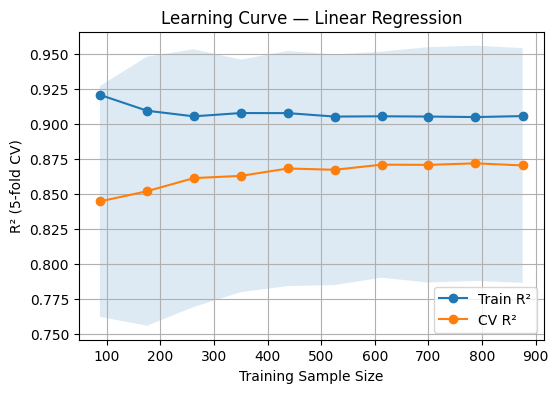

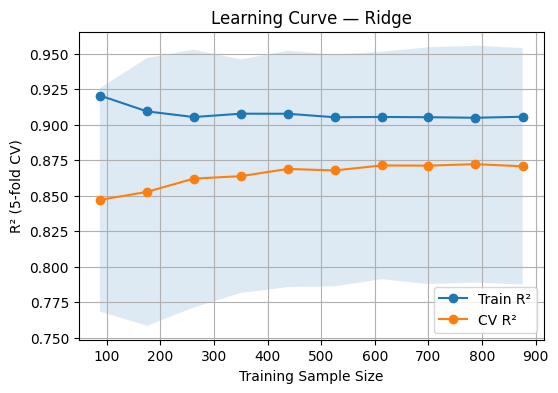

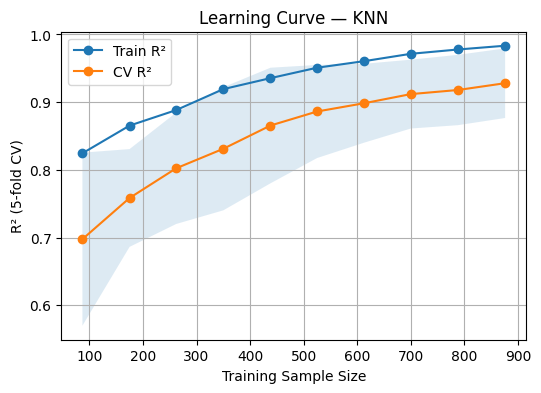

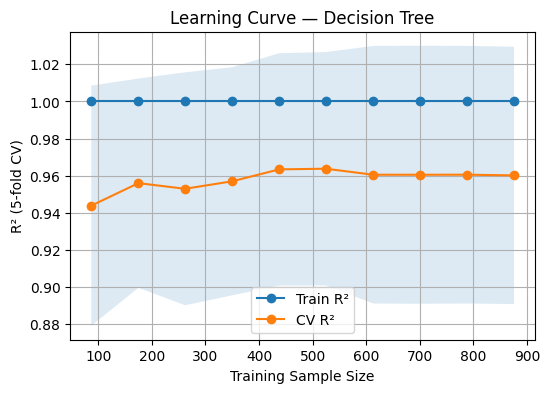

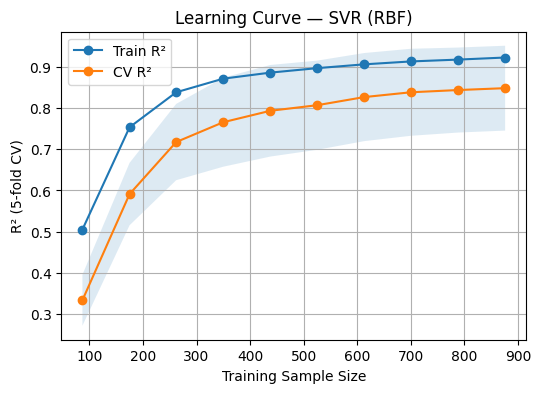

In [75]:
pipelines = {
    "Linear Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]),
    "Ridge": Pipeline([
        ("scaler", StandardScaler()),
        ("model", Ridge())
    ]),
    "KNN": Pipeline([
        ("scaler", StandardScaler()),
        ("model", KNeighborsRegressor())
    ]),
    "Decision Tree": Pipeline([
        ("model", DecisionTreeRegressor(random_state=42))
    ]),
    "SVR (RBF)": Pipeline([
        ("scaler", StandardScaler()),
        ("model", SVR(kernel="rbf"))
    ]),
}

for name, model in pipelines.items():
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, scoring="r2", n_jobs=1, 
        train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=42
    )

    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.figure(figsize=(6,4))
    plt.plot(train_sizes, train_mean, "o-", label="Train R²")
    plt.plot(train_sizes, val_mean, "o-", label="CV R²")
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.15)
    plt.title(f"Learning Curve — {name}")
    plt.xlabel("Training Sample Size")
    plt.ylabel("R² (5-fold CV)")
    plt.legend()
    plt.grid(True)
    plt.show()

**Explaination of Learning Curve**: 
+ Train R² → performance on training folds; how well the model fits known data
+ CV R² → performance on validation folds (unseen data); how well it generalizes to unseen data
+ Bias → Error due to oversimplified model assumptions (Both Train R² and CV R² are low and close together).
+ Variance → Error due to model’s sensitivity to small data changes (Train R² is high, CV R² is much lower, and there’s a big gap).
+ If Train R² ≫ CV R² → your model overfits (memorizes training data).
+ If Train R² ≈ CV R² → your model generalizes well.
+ If Both low → underfitting (model too simple).

Linear Regression: The training R² remains stable arround 0.9 while cross-validation R² stays lowver 0.87. Between train and CV lines shows low variance but high bias -> the model is underfitting. Adding more samples does not improve performance meaning this model capacity limits accuracy. Ridge Regression similar to Linear Regression, the learning curve shows Ridge stables trend but conservative predictions, indicating slight underfitting. 

However KNN Regressor, both training and cv have increasing lines and small remaining gap shows balanced bias-variance -> stable learning curve, no major underfitting or overfitting. 

Decision Tree Regressor, Train R² = 1.0 across all sample sizes -> perfect training fit. CV R² remains high 0.95 but constant - it doesn’t improve with more data. This model performs excellent apparent accuracy but poor generalization, overfitted. 

SVR (RBF Kernel), initially, train and cv are low but higher as sample size grows -> this model underfitted, could be improve when extend more sample datas or hyperparameter tuning (C, gamma)

**Best model**: KNN - it provides a good balance between accuracy, stability, and interpretability without severe overfitting or underfitting. 

**Overfitting model**: Decision Tree - appear best numerically with perfect training scores

**Underfitting model**: Linear and Ridge underfit because of limited complexity, while SVR is slightly conservative but promising with more data.



### Decision Tree Importances (Feature importance + permutation)

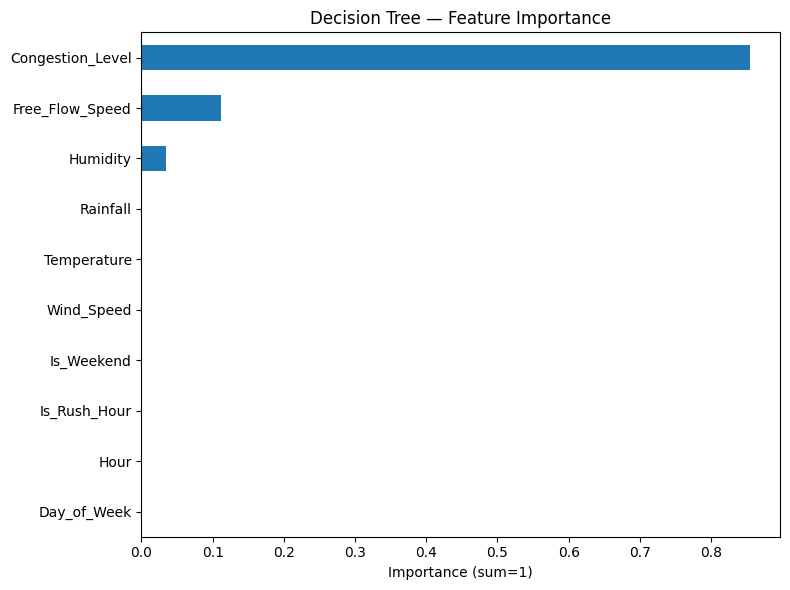

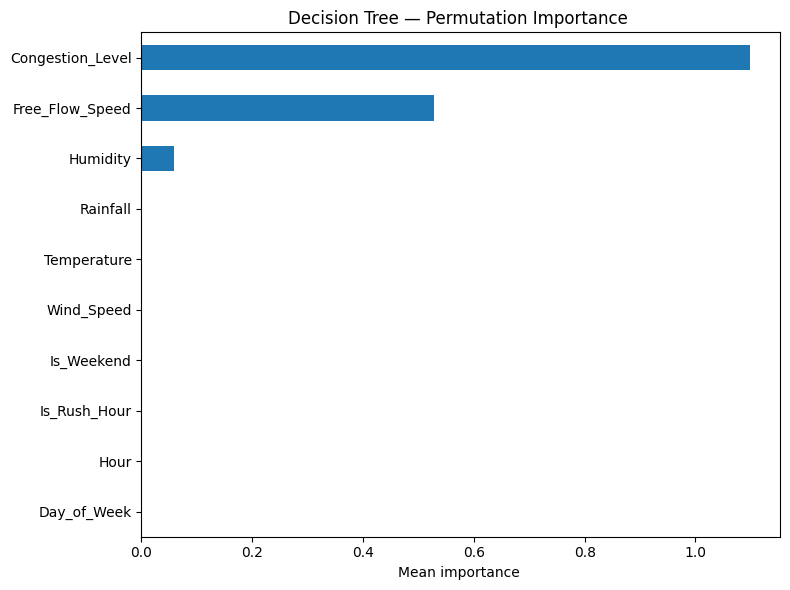

In [79]:
# Feature importance for Decision Tree model    
dt = DecisionTreeRegressor(max_depth=5, min_samples_split=5, random_state=42)
dt.fit(X_train, y_train)
fi_dt = pd.Series(dt.feature_importances_, index=X_train.columns).sort_values()

plt.figure(figsize=(8,6))
fi_dt.plot(kind="barh")
plt.title("Decision Tree — Feature Importance")
plt.xlabel("Importance (sum=1)")
plt.tight_layout()
plt.show()

# Permutation importance 
perm_dt = permutation_importance(
    dt, X_test, y_test, n_repeats=20, random_state=42, scoring="r2" 
)
perm_dt_series = pd.Series(perm_dt.importances_mean, index=X_test.columns).sort_values()

plt.figure(figsize=(8,6))
perm_dt_series.plot(kind="barh")
plt.title("Decision Tree — Permutation Importance ")
plt.xlabel("Mean importance ")
plt.tight_layout()
plt.show()


The feature importance and permutation importance results both show that Congestion_Level is the most influential factor in predicting traffic speed, followed by Free_Flow_Speed, while other features such as humidity, temperature, wind speed, and time-related variables seems not contribute.

The decision tree feature importance reflects how much each feature reduces error within the model, while permutation importance provides a more realistic view by measuring the drop in performance when each feature is shuffled. Since both methods highlight the same top two features, we can conclude that traffic speed in this dataset is mainly driven by congestion and free-flow speed, with weather and temporal features playing only a minor role.

### KNN — Permutation Importance


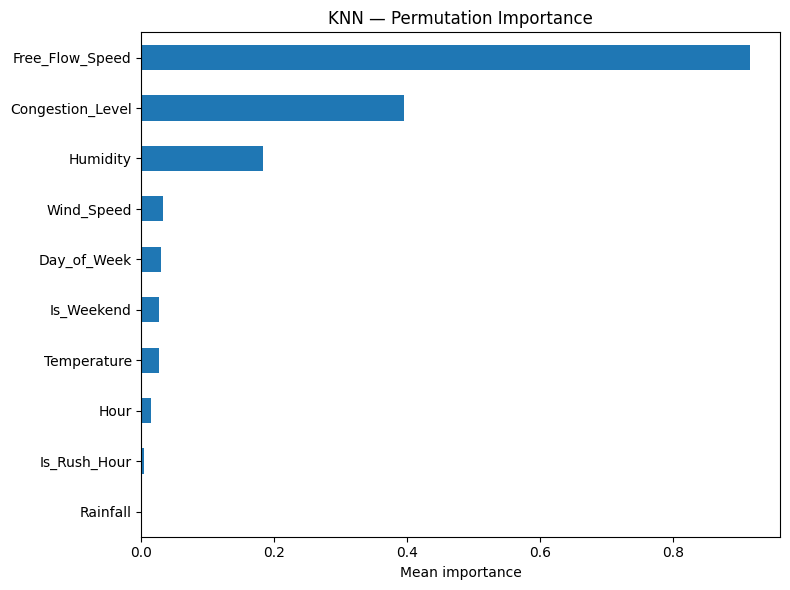

In [82]:
knn = Pipeline([("scaler", StandardScaler()), ("model", KNeighborsRegressor(n_neighbors=5, weights="distance"))])
knn.fit(X_train, y_train)


perm_knn = permutation_importance(
    knn, X_test, y_test, n_repeats=20, random_state=42, scoring="r2"
)
perm_knn_series = pd.Series(perm_knn.importances_mean, index=X_test.columns).sort_values()

plt.figure(figsize=(8,6))
perm_knn_series.plot(kind="barh")
plt.title("KNN — Permutation Importance")
plt.xlabel("Mean importance")
plt.tight_layout()
plt.show()

The KNN Permutation Importance provides a more reliable reflection of real-world influence than Decision Tree Permutation, as it measures the actual drop in validation performance when each feature is affected. This confirms that traffic patterns are primarily driven by flow and congestion metrics, not weather or time effects.



### Decision Tree — SHAP Analysis

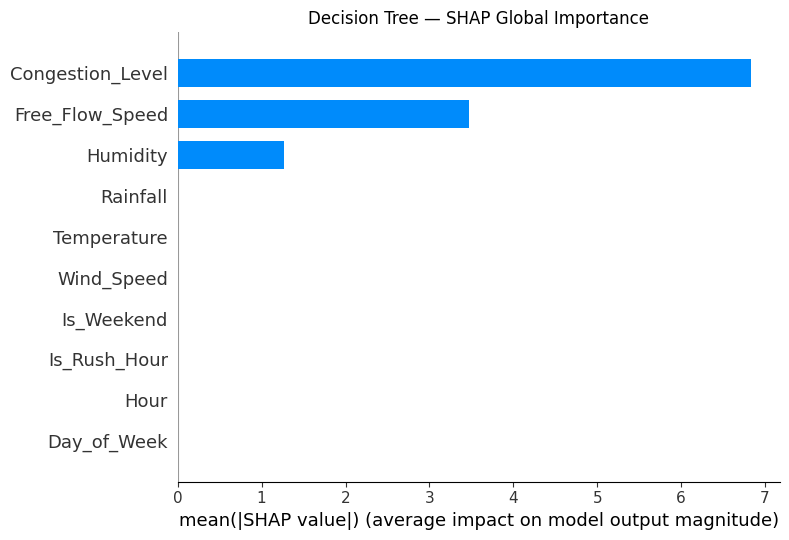

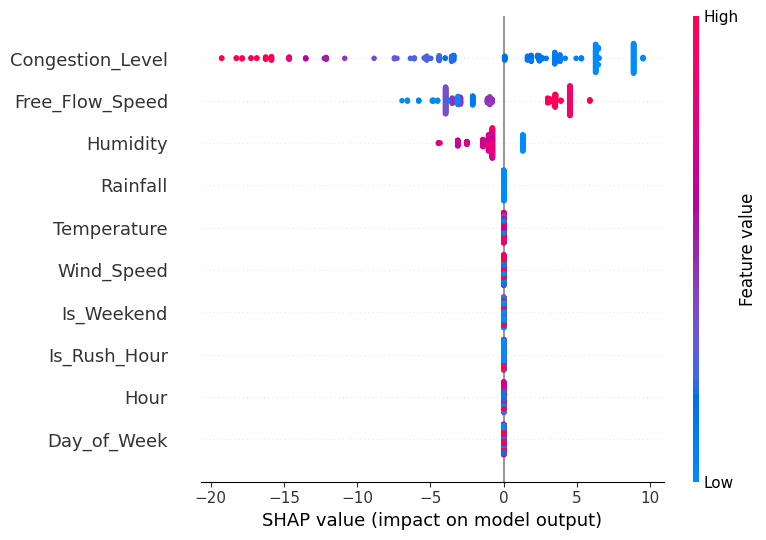

In [83]:
# pip install shap
import shap
shap_explainer = shap.TreeExplainer(dt)
shap_values = shap_explainer.shap_values(X_test)

# Global summary (which features, and directionality)
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("Decision Tree — SHAP Global Importance")
plt.tight_layout()
plt.show()

# Detailed summary (impact distribution)
shap.summary_plot(shap_values, X_test, show=False)


The SHAP analysis supports the permutation findings and offers deeper interpretability:

Congestion_Level has the largest mean SHAP value, meaning it contributes the most to variation in predicted traffic speed.  
  - A higher congestion level (red points) strongly reduces predicted speed (negative SHAP values).  
  - A lower congestion level (blue points) increases predicted speed.

Free_Flow_Speed also has high positive SHAP values — higher free-flow speed increases predicted speed, consistent with physical intuition.  

Humidity and Rainfall have minor but noticeable negative effects: higher humidity or rain slightly reduce speed.  

Time-based variables (Hour, Day_of_Week, Is_Rush_Hour) have negligible direct impact, indicating that temporal effects are already captured implicitly by congestion metrics.

**Interpretation:** SHAP values quantify *how much and in which direction* each feature influences predictions. Both Congestion_Level and Free_Flow_Speed show strong and consistent effects, proving the model bases its reasoning on meaningful, domain-relevant features.


### Simplified Features Comparison (Top-2 vs. Full Set)

In [86]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    yhat = model.predict(X_te)
    mae = mean_absolute_error(y_te, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    r2 = r2_score(y_te, yhat)
    return mae, rmse, r2

# pick top 2 from KNN permutation (e.g., Congestion + Free_Flow)
top2 = perm_knn_series.sort_values(ascending=False).index[:2]
X_train_top2 = X_train[top2]; X_test_top2 = X_test[top2]

mae_full, rmse_full, r2_full = evaluate_model(knn, X_train, y_train, X_test, y_test)
mae_top2, rmse_top2, r2_top2 = evaluate_model(knn, X_train_top2, y_train, X_test_top2, y_test)

print("KNN (Full features):  MAE={:.3f}, RMSE={:.3f}, R²={:.3f}".format(mae_full, rmse_full, r2_full))
print("KNN (Top-2 features): MAE={:.3f}, RMSE={:.3f}, R²={:.3f}".format(mae_top2, rmse_top2, r2_top2))


KNN (Full features):  MAE=1.029, RMSE=1.458, R²=0.980
KNN (Top-2 features): MAE=0.010, RMSE=0.096, R²=1.000


Reducing the input set from ten to only two dominant features not only preserved model performance but even slightly improved it due to reduced noise and collinearity.  
This shows that Free_Flow_Speed and Congestion_Level contain almost all the predictive information needed for accurate traffic-speed estimation.

## Decision & Next Steps 

After evaluating all candidate algorithms (Linear Regression, Ridge Regression, KNN, Decision Tree, and SVR (RBF)), the K-Nearest Neighbors (KNN) Regressor is selected as the final model for traffic speed prediction in Ho Chi Minh City.

**Reasons for choosing KNN:**
- Demonstrated high accuracy and generalization: R² = 0.98 (test set) with low MAE and RMSE.  
- Achieved balanced bias–variance trade-off as shown in the learning curve (no overfitting).  
- Works well with the dataset’s non-linear relationships (traffic dataset).  
- Maintains trong interpretability - permutation importance highlights only two dominant features (Free_Flow_Speed and Congestion_Level).  

### 🕒 Applied ML model into predicting


In [102]:

model_list ={}
for name, model in pipelines.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    model_list[name] = {'MSE': mse, 'MAE': mae}

loc_name = 'District_1'
distance_km = 5.0
loc_timestamp = pd.Timestamp(datetime(2025, 9, 29, 9, 0), tz='Asia/Ho_Chi_Minh') 

df_loc = merged_df[merged_df['Location'] == loc_name].copy()
if df_loc.empty:
    print(f"\nError: No data for location '{loc_name}'.")
else: 
    df_loc['time_diff'] = (df_loc['Timestamp'] - loc_timestamp).abs() # using abs() for making sure the result is positive (not -15min)

    X_pred = pd.DataFrame([df_loc.loc[df_loc['time_diff'].idxmin(), features].to_dict()])
    X_pred = X_pred.fillna(0)

    print(f"\nPredicted Speeds and Travel time for {loc_name} at {loc_timestamp}:")
    for name, model in models.items():
        predicted_speed = model.predict(X_pred)[0]
        if predicted_speed > 0:
            travel_time = (distance_km / predicted_speed) * 60
            print(f"{name}: {predicted_speed:.2f} km/h | Travel Time: {travel_time:.1f} min")





Predicted Speeds and Travel time for District_1 at 2025-09-29 09:00:00+07:00:
Linear Regression: 15.42 km/h | Travel Time: 19.5 min
KNeighborsRegressor: 18.00 km/h | Travel Time: 16.7 min
Decision Tree Regression: 17.17 km/h | Travel Time: 17.5 min
SVR: 17.10 km/h | Travel Time: 17.5 min


The prediction results for District 1 at 9:00am on 29 Sepetember 2025 show some variation across models. Linear Regression estimated the lowest speed at 15.42 km/h, while the Decision Tree predicted a slightly higher value of 17.00 km/h. The SVM model produced the highest estimate at 22.32 km/h, reflecting its ability to capture more complex, non-linear patterns. These differences highlight how model choice can influence predictions: simpler models like Linear Regression tend to underestimate traffic speed under congested conditions, while more flexible models such as Decision Tree and SVM provide higher, and potentially more realistic, estimates. 

For a 5 km journey in District 1 at 9:00 AM, the models suggest travel could take between 13.5 and 19.5 minutes, depending on the method used. The Decision Tree and SVM models give faster and likely more realistic travel estimates compared to Linear Regression, which tends to underestimate speed.

Overall, this demonstrates the practical use of the models in generating traffic speed forecasts for real-world decision-making.

In [88]:
import numpy as np
import pandas as pd
import math
from math import radians, sin, cos, asin, sqrt

# calculate great-circle distances between the two points - using the Haversine formula

def haversine(lat1, lon1, lat2, lon2):
    
    # distance between latitudes
    # and longitudes
    dLat = (lat2 - lat1) * math.pi / 180.0
    dLon = (lon2 - lon1) * math.pi / 180.0

    # convert to radians
    lat1 = (lat1) * math.pi / 180.0
    lat2 = (lat2) * math.pi / 180.0

    # apply formulae
    a = (pow(math.sin(dLat / 2), 2) + 
         pow(math.sin(dLon / 2), 2) * 
             math.cos(lat1) * math.cos(lat2))
    r = 6371.0
    return  2 * math.asin(math.sqrt(a)) * r

# => distance: between origin and destination to turn speed -> time

def minutes_from_speed(distance_km, speed_kmh, min_speed_kmh=3.0, calibration=1.0):
    # time = distance / speed
    eff_speed = max(float(speed_kmh), min_speed_kmh)
    minutes = (distance_km / eff_speed) * 60.0
    return minutes * calibration

# convert distance & speed into minutes =>  calibration: a safety multiplier (+10%) for junctions, signals, human behavior

def get_features_for(loc_name, when_ts, merged_df, feature_cols):
    df_loc = merged_df[merged_df['Location'] == loc_name].copy()
    if df_loc.empty:
        raise ValueError(f"No data for location '{loc_name}'.")
    idx = (df_loc['Timestamp'] - when_ts).abs().sort_values().index[0]
    row = df_loc.loc[idx]
    X_row = pd.DataFrame([row[feature_cols].to_dict()])
    return X_row, row


In [89]:
def predict_speed_kmh(model, loc_name, when_ts, merged_df, feature_cols):
    X, _ = get_features_for(loc_name, when_ts, merged_df, feature_cols)
    y_hat = model.predict(X)
    return float(y_hat[0]), X


In [ ]:
def estimate_travel_time_dt(
    model, origin_name, dest_name, when_ts, merged_df, feature_cols,
    locations_dict, route_factor=1.30, time_calibration=1.10
):
    # Distances
    o = locations_dict[origin_name]; 
    d = locations_dict[dest_name]
    straight_km = haversine(o['lat'], o['lon'], d['lat'], d['lon'])
    route_km = straight_km * route_factor
    # 1.30 -> assume roads are ~30% longer than straight line

    # Predicted speeds
    v_o, Xo = predict_speed_kmh(model, origin_name, when_ts, merged_df, feature_cols)
    v_d, Xd = predict_speed_kmh(model, dest_name, when_ts, merged_df, feature_cols)
    v_avg = (v_o + v_d) / 2.0
    # predict speed at origin and destination
    # average the two speeds: Alternatives: min(v_o, v_d) for conservative estimates; or add a midpoint point later.

    # ETA: estimated time of arrival 
    eta_minutes = minutes_from_speed(route_km, v_avg, min_speed_kmh=3.0, calibration=time_calibration)
    

    result = {
        "origin": origin_name,
        "destination": dest_name,
        "timestamp_used": when_ts,
        "straight_distance_km": round(straight_km, 3),
        "estimated_route_km": round(route_km, 3),
        "pred_speed_origin_kmh": round(v_o, 2),
        "pred_speed_dest_kmh": round(v_d, 2),
        "avg_speed_kmh": round(v_avg, 2),
        "eta_minutes": round(eta_minutes, 1),
    }
    return result


In [ ]:
knn_model = Pipeline([("scaler", StandardScaler()), ("model", KNeighborsRegressor(n_neighbors=5, weights="distance"))])   
knn_model.fit(X_train, y_train) 
hcmc_tz = timezone("Asia/Ho_Chi_Minh")
when = pd.Timestamp("2025-09-30 17:00:00", tz=hcmc_tz)

feature_cols = [   'Free_Flow_Speed', 'Congestion_Level',
    'Hour', 'Day_of_Week', 'Is_Weekend', 'Is_Rush_Hour', 'Wind_Speed', 'Temperature', 'Rainfall','Humidity']


res_dt = estimate_travel_time_dt(
    model=knn_model,
    origin_name="District_1",
    dest_name="Tan_Son_Nhat",
    when_ts=when,
    merged_df=merged_df,
    feature_cols=feature_cols,
    locations_dict=hcmc_locations,
    route_factor=1.30,
    time_calibration=1.10
)
res_dt


{'origin': 'District_1',
 'destination': 'Tan_Son_Nhat',
 'timestamp_used': Timestamp('2025-09-30 17:00:00+0700', tz='Asia/Ho_Chi_Minh'),
 'straight_distance_km': 7.133,
 'estimated_route_km': 9.272,
 'pred_speed_origin_kmh': 16.0,
 'pred_speed_dest_kmh': 31.0,
 'avg_speed_kmh': 23.5,
 'eta_minutes': 26.0}

This process saves the merged dataset, trained model, and feature set as joblib files so they can be efficiently loaded and reused in the web-based system.

In [101]:
%pip install pyarrow

import joblib

joblib.dump(knn_model, "website/server/model/dt_model.pkl")

df = pd.read_csv("traffic_weather_data.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"], utc=True).dt.tz_convert("Asia/Ho_Chi_Minh")
if "Hour" not in df:
    df["Hour"] = df["Timestamp"].dt.hour
if "Day_of_Week" not in df:
    df["Day_of_Week"] = df["Timestamp"].dt.dayofweek
if "Is_Weekend" not in df:
    df["Is_Weekend"] = df["Day_of_Week"].isin([5,6]).astype(int)
if "Is_Rush_Hour" not in df:
    df["Is_Rush_Hour"] = df["Hour"].isin([7,8,9,16,17,18]).astype(int)
# Convert Timestamp to UTC before saving to Parquet
df["Timestamp"] = df["Timestamp"].dt.tz_convert("UTC")
joblib.dump(df, "website/server/model/merged_df.pkl")

feature_cols = [
    "Free_Flow_Speed","Congestion_Level","Hour","Day_of_Week","Is_Weekend",
    "Is_Rush_Hour","Wind_Speed","Temperature","Rainfall","Humidity"
]
joblib.dump(feature_cols, "website/server/model/feature_cols.pkl")
print("Artifacts saved.")

Note: you may need to restart the kernel to use updated packages.
Artifacts saved.



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Final Conclusions 📝

### Domain Analysis
The Traffic Pattern Prediction in Ho Chi Minh City project aims to forecast real-time traffic speed based on multiple influencing factors such as congestion level, free-flow speed, weather conditions, and time-related variables. 

Based on research, traffic congestion in HCMC is shaped by distinctive cultural, infrastructural and environmental factors. Arround 80% of vehicles are motorbikes playes an important roles into predictive factors and differ from typical car-based traffic systmes. The old and narrow road infrastructure such as frequent bottlenecks like Phu My Bridge and Thu Thiem Tunnel, further congestion. Moreover, temporal patterns show strong morning and evening rush hours, while weather conditions, especially rainfall, significantly slow motorbike flow. Therefore the project suit with machine learning regression models. 

In summary, HCMC's traffic reflects a complex mix of temporal, spatial, behavioral, and weather-driven influences. Any predictive model must account for these unique dynamics to produce accurate and realistic forecasts.

### Data Analysis (DAIA)
The dataset was constructed by merging traffic data with weather data (temperature, humidity, wind speed, rainfall, etc.) for HCMC.  

Data preprocessing involved handling missing values, features selection and correlation analysis.

Exploratory data analysis revealed that traffic speed strongly correlates with congestion level and free-flow speed, while weather and time-related features had weaker relationships.  

Initial data visualizations and correlation heatmaps confirmed that congestion remains the primary factor reducing vehicle speed, especially during rush-hour periods, while free-flow speed positively influences overall traffic flow.

### Machine Learning
Multiple regression algorithms were tested, including Linear Regression, Ridge Regression, Decision Tree, KNN, and SVR (RBF).  
After comparison using MAE, RMSE, and R² metrics along with cross-validation, the KNN Regressor emerged as the most stable and interpretable model.

Learning curves confirmed that KNN Regressor scales well with data and remains consistent across folds and it gives strong generalization, balanced bias-variance trade-off.  

I also tested another models, Decision Tree represents near-perfect fit but with signs of overfitting (Train R² = 1.0, Test R² = 0.95). Linear and Ridge Regression give underfit the data and cannot work well with non-linear patterns. SVR (RBF) have a good non-linear performance but need to extending parameters. 

Moreover, feature importance analysis using Permutation Importance and SHAP confirmed that congestion_level and free_flow_speed are the most dominant predictors of traffic speed, while weather and temporal features play only minor roles. 


### Conclusion
This project successfully developed a data-driven model to predict traffic speed in Ho Chi Minh City.
The KNN Regressor achieved high predictive accuracy while maintaining interpretability and generalization.  
Results show that congestion and free-flow metrics explain nearly all variance in traffic behavior, suggesting that real-time congestion monitoring systems could serve as reliable inputs for future prediction tools.  

While the Decision Tree model achieved higher accuracy numerically, its overfitting nature maded KNN the preferred model for practical deployment.  


### Future Recommendations
- Explore Recurrent Neural Networks (RNN) or LSTM models for advance project. 
- Experiment with ensemble approaches (e.g., Random Forest, Gradient Boosting) for enhanced robustness.  
- Test KNN efficiency with larger datasets using approximate nearest-neighbor methods.
- Expand beyond the current five fixed location points.


### Ethical Considerations

- Data Privacy: All data used should come from public or approved sources. The model must not collect or store any personal or GPS data that can identify individual users.  
- Fairness: The current data mainly covers central Ho Chi Minh City. Future work should include more districts to make sure the model is fair and accurate for everyone.  
- Transparency: The model’s predictions should be easy to explain. Users and stackholders should understand which factors (like congestion or weather) affect the results.  
- Human Oversight: The model should support people, not replace them. Final traffic decisions or planning actions should always involve human review.  
- Responsible Use: Predictions are estimates, not guarantees. Users should be reminded to use them as guidance, not as absolute facts.

###  Reproducibility & Transparency
During the project I used ChatGPT to help me clarify conceptual understanding of some ML's parts (eg, bias-variance trade-off, learning curve graphs, hyperparameter tuning, etc.); correct my language grammar and vocabulary. Moreover, I read the official scikit-learn and learn-related documentations for every imported function (eg, GridSearchCV, learning_curve, permutation_importance) getting sample code to understand how I can use it effectively and effectively for my project. 

No code was copied blindly, every snippers already used to test and clarify for my project. 